In [1]:
#IMPORT LIBRARIES
import numpy as np 
import cv2 
import os 

from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

from tensorflow import keras
from keras.models import load_model

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatch
%matplotlib inline

from mtcnn import MTCNN #face detection

import pickle

Using TensorFlow backend.


In [2]:
#DIR 

folder_path = r"C:\Users\Simone\Desktop\face_proj/" #path of the folder with the material for the project


#MODELS

#FaceNet
FaceNet_model_name = 'facenet_keras.h5'
Face_Net_model = load_model(folder_path + FaceNet_model_name, compile = False)


#SVC
pred_model_save_name = 'myModel' #name with which you wish to save the prediction model for future use, for training purposes only
pred_model = 'myModel' #name of the model you want to use to make predictions

SVC_model = SVC(kernel='linear', probability = True)

#Face detector and vector normalizer
detector = MTCNN() #face detector model
normalizer = Normalizer(norm= 'l2')



#FUNCTIONS

#detect and cut face for the training process, then also resize the picture
def cut_face(image):
    
    '''
    Detects and cuts face for the training process (with a single face for each image!); 
    then also resize the face for the FaceNet model
    '''
    
    size = (160,160)
    #detects face and gets starting and ending point for the rectangle
    results = detector.detect_faces(image)
    rectangle =  results[0]['box']
    for number in range(len(rectangle)):
        if rectangle[number] < 0:
            rectangle[number] = 0
    
    #cuts the picture keeping only the face!
    cropped_img = image[rectangle[1]:rectangle[1] + rectangle[3], rectangle[0]:rectangle[0] + rectangle[2]]
    
    if cropped_img.shape < size:
        image_norm = cv2.resize(cropped_img, size, 
                                    interpolation=cv2.INTER_AREA)
    else:
        image_norm = cv2.resize(cropped_img, size, 
                                    interpolation=cv2.INTER_CUBIC)
        

    return image_norm


def standardize_expand_image(image):
    
    '''
    Standardize each image with its mean 
    and std_dev and creates a tensor object
    '''
    
    image.astype('float32')
    #get mean and stdev
    mean, std = image.mean(), image.std()
    #standardize
    image = (image - mean) / std
    #tensor
    tensor = keras.backend.expand_dims(image, axis=0)
    
    return tensor


def dataset():
    '''
    imports all images and associated 
    labels for the training process from
    the 'people' subfolder
    '''
    images = []
    labels = []
    labels_dic = {}
    people = [person for person in os.listdir(folder_path + 'people/')]
    for i, person in enumerate(people):
        labels_dic[i] = person
        for image in os.listdir(folder_path + 'people/' + person):
            images.append(cv2.cvtColor(cv2.imread(folder_path + 'people/' + person + '/' + image), cv2.COLOR_BGR2RGB))
            labels.append(person)
    return (images, np.array(labels), labels_dic)


    
def gimme_embeddings(image):
    '''
    returns the output embeddings 
    from the FaceNet model
    '''
    return Face_Net_model.predict(image,steps = 1)[0]



def prediction_from_dictionary(dictionary, pred_model, labels, prediction_confidence):
    '''
    takes the following dictionary as input:
    
    {
    'rectangles' : [(x1,y2,width,height), (x2,y2,width,height), ...] ---> all_detected_faces_coordinates
    'original_pic' : 3d array with the original picture 
    'predictions' : [] ---> empty list 
    }
    
    and returns the same dictionary appending 
    the predictions (with the true label) for each face, 
    taken by cutting each rectangle out of the original_pic, 
    preparing them for the prediction model and getting the result
    '''
    
    size = (160,160) #defines the img size our predictive model desires
    for rectangle in dictionary['rectangles']:
        cropped_img = dictionary['original_pic'][rectangle[1]:rectangle[1] + rectangle[3], 
                                                 rectangle[0]:rectangle[0] + rectangle[2]]

        if cropped_img.shape < size:
            image_norm = cv2.resize(cropped_img, size, 
                                        interpolation=cv2.INTER_AREA)
        else:
            image_norm = cv2.resize(cropped_img, size, 
                                        interpolation=cv2.INTER_CUBIC)
        
        #standardize and makes a tensor for each face
        tensor = list(map(standardize_expand_image,[image_norm]))
        
        
        #get embeddings using FaceNet model
        embeddings = np.array(list(map(gimme_embeddings,tensor)))
                    
        #normalize the vectors
        to_predict = normalizer.transform(embeddings)
        
        #get prediction and prediction probability
        prediction = pred_model.predict(to_predict)
        prob = pred_model.predict_proba(to_predict)[0][prediction[0]]
        
        if prob > prediction_confidence:
            real_name = labels[prediction[0]]
            dictionary['predictions'].append(real_name)
        else:
            dictionary['predictions'].append('????')
        
    return dictionary

# Train predictive model

In [3]:
#save train images and labels into arrays
full_images, labels, labels_dic = dataset()

inverse_labels_dict = {}
for x in labels_dic:
    inverse_labels_dict[labels_dic[x]] = x
y = np.array([inverse_labels_dict[x] for x in labels])

#cut out only the face and reshapes for the model
just_faces = list(map(cut_face,full_images))

#standardize and makes a tensor for each face
tensors = list(map(standardize_expand_image,just_faces))

#get embeddings using FaceNet model
embeddings = np.array(list(map(gimme_embeddings,tensors)))

#normalize the vectors
x = normalizer.transform(embeddings)

#fit the model
SVC_model.fit(x,y)

#save the model and relative labels
pickle.dump(SVC_model, open(folder_path + 'code_stuff\predictive_models/' + pred_model_save_name + '.sav', 'wb'))
pickle.dump(labels_dic, open(folder_path + 'code_stuff\predictive_models/' + pred_model_save_name + '_labels' + '.txt', 'wb'))

# Predictions

In [4]:
#confidence for the detection of the faces inside an image (low number might cause false positives detections)
FACE_DETECTION_CONFIDENCE = 0.97 

#if, when detecting a face, its accuracy probability is below PREDICTION_CONFIDENCE, 
#the prediction will be 'Intruder Detected'
PREDICTION_CONFIDENCE = 0.35 


SVC_model = pickle.load(open(folder_path + 'code_stuff\predictive_models/' + pred_model + '.sav','rb'))
labels = pickle.load(open(folder_path + 'code_stuff\predictive_models/' + pred_model + '_labels' + '.txt','rb'))


to_predict = []
for image in os.listdir(folder_path + 'to_predict'):
    to_predict.append(cv2.cvtColor(cv2.imread(folder_path + 'to_predict' + '/' + image), cv2.COLOR_BGR2RGB))

dic = {}

for index in np.arange(len(to_predict)):
    image = to_predict[index]

    #finds all the faces in the picture
    detections = detector.detect_faces(image) 


    dic[index] = {}
    dic[index]['original_pic'] = image
    dic[index]['rectangles'] = []
    dic[index]['predictions'] = [] 

    for x in np.arange(len(detections)):
        if detections[x]['confidence'] > FACE_DETECTION_CONFIDENCE:
            box = detections[x]['box']
            for co in np.arange(len((box))):
                if box[co] < 0:
                    box[co] = 0
            dic[index]['rectangles'].append(detections[x]['box'])


for index in np.arange(len(dic)):
    dic[index] = prediction_from_dictionary(dic[index], SVC_model, labels,PREDICTION_CONFIDENCE)

# Plot predictions

<Figure size 3600x3600 with 0 Axes>

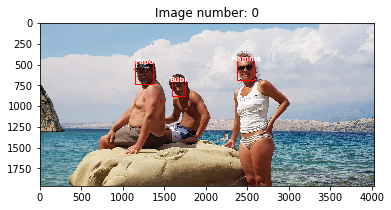

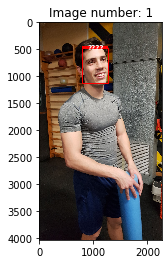

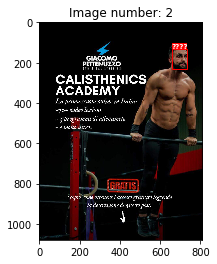

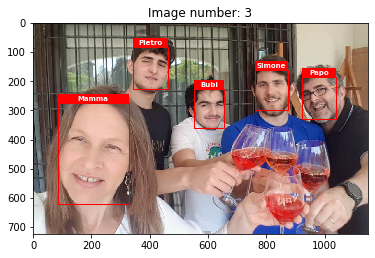

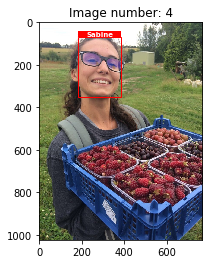

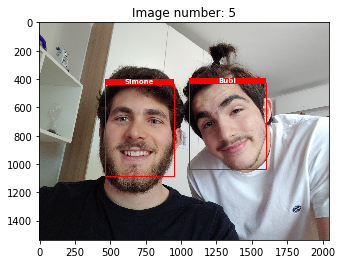

In [5]:
#show predictions
plt.figure(figsize=(50,50))
number_of_imgs = len(dic)
for i in np.arange(number_of_imgs):
    
    fig,ax = plt.subplots()
    plt.imshow(dic[i]['original_pic'])
    
    rectangles = {}
    
    for x in np.arange(len(dic[i]['rectangles'])):
        prediction = dic[i]['predictions'][x]
        
        box = dic[i]['rectangles'][x]
        startpoint = (box[0],box[1])
        width = box[2]
        height = box[3]
        
        face_box = patches.Rectangle(startpoint,width,height,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(face_box)
        
        label_startpoint = (startpoint[0], startpoint[1] - 30)
        
        rectangles[prediction] = mpatch.Rectangle(label_startpoint, width, 30,facecolor='red')
        
    for r in rectangles:
        ax.add_artist(rectangles[r])
        rx, ry = rectangles[r].get_xy()
        
        width = rectangles[r].get_width()
        height = rectangles[r].get_height()
        
        cx = rx + width/2.0
        cy = ry + height/2.0
        
        
        ax.annotate(r, (cx, cy), color='w', weight='bold', 
                    fontsize=7, ha='center', va='center') 
        
        
    plt.title('Image number: {}'.format(i))
    plt.show()
    